In [1]:
import torch
import pandas as pd
import numpy as np
from PIL import Image

In [23]:
from torch.utils.data import Dataset, SubsetRandomSampler
from PIL import Image

class DigitDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        if self.dataframe.shape[1] == 785:
            data = self.dataframe.iloc[idx, 1:].values
        else:
            data = self.dataframe.iloc[:].values
        data = data.reshape((28, 28))
        data = np.asarray(data, np.uint8)
        data = Image.fromarray(data, mode='L')
        target = self.dataframe.iloc[idx, 0]

        if self.transform:
            data = self.transform(data)

        return data, target

In [3]:
from torchvision import transforms

train_dataset = DigitDataset(
    "/kaggle/input/digit-recognizer/train.csv",
    transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                       ])
)

In [4]:
batch_size = 128

data_size = len(train_dataset)
validation_fraction = 0.2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))

np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler
)

val_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=val_sampler
)

In [5]:
device = torch.device("cuda:0") 

In [6]:
def train_model(model, train_loader, val_loader, optimizer, loss, scheduler, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0.0
        correct_samples = 0
        total_samples = 0
        
        for idx, (X, y) in enumerate(train_loader):
            X_gpu = X.to(device)
            y_gpu = y.to(device)
            
            preds = model(X_gpu)
            loss_value = loss(preds, y_gpu)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(preds, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
        ave_loss = loss_accum / idx
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        scheduler.step(ave_loss)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
    
    
def compute_accuracy(model, val_loader):
    model.eval()
    
    correct_samples = 0
    total_samples = 0
    
    for idx, (X, y) in enumerate(val_loader):
        X_gpu = X.to(device)
        y_gpu = y.to(device)
        
        preds = model(X_gpu)
        
        _, indices = torch.max(preds, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
        
    return float(correct_samples) / total_samples

In [39]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

model = models.resnet18(weights='IMAGENET1K_V1')

model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

model.type(torch.cuda.FloatTensor)
model = model.to(device)


parameters = model.fc.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)


In [40]:
loss_history, train_history, val_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss=loss,
    scheduler=scheduler,
    num_epochs=25
)

Average loss: 0.125397, Train accuracy: 0.972976, Val accuracy: 0.978690
Average loss: 0.057549, Train accuracy: 0.983036, Val accuracy: 0.967738
Average loss: 0.057950, Train accuracy: 0.982708, Val accuracy: 0.957381
Average loss: 0.052673, Train accuracy: 0.984464, Val accuracy: 0.959881
Average loss: 0.054345, Train accuracy: 0.984345, Val accuracy: 0.985476
Average loss: 0.051937, Train accuracy: 0.984435, Val accuracy: 0.976905
Average loss: 0.045042, Train accuracy: 0.987321, Val accuracy: 0.987024
Average loss: 0.043958, Train accuracy: 0.988125, Val accuracy: 0.986667
Average loss: 0.042374, Train accuracy: 0.988631, Val accuracy: 0.987500
Average loss: 0.039995, Train accuracy: 0.989702, Val accuracy: 0.986548
Average loss: 0.034980, Train accuracy: 0.991071, Val accuracy: 0.981310
Average loss: 0.035459, Train accuracy: 0.991488, Val accuracy: 0.979405
Average loss: 0.036204, Train accuracy: 0.990595, Val accuracy: 0.981667
Average loss: 0.031673, Train accuracy: 0.992262, V

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline

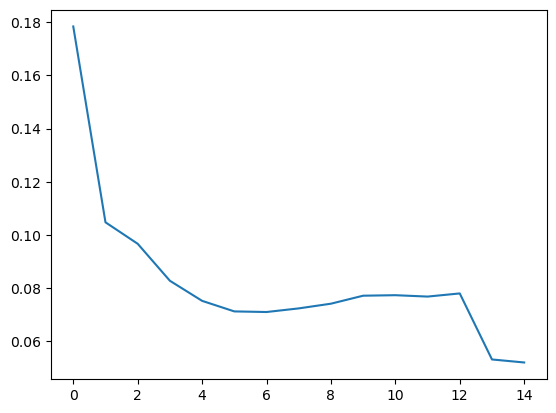

In [19]:
plt.plot(loss_history)

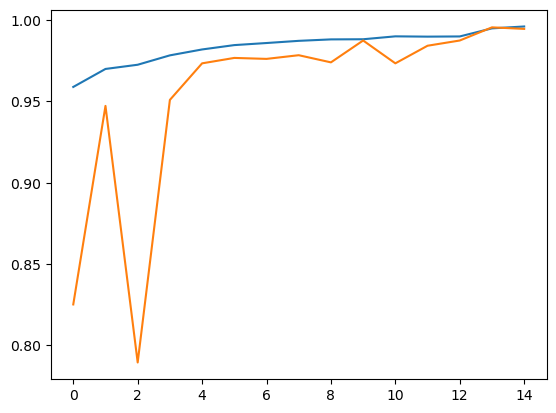

In [20]:
plt.plot(train_history)
plt.plot(val_history)

In [41]:
from torch.utils.data import Dataset, SubsetRandomSampler
from PIL import Image

class DigitDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.dataframe["tmp"] = 1
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        data = self.dataframe.iloc[idx, 1:].values
        data = data.reshape((28, 28))
        data = np.asarray(data, np.uint8)
        data = Image.fromarray(data, mode='L')
        target = self.dataframe.iloc[idx, 0]

        if self.transform:
            data = self.transform(data)

        return data, target

In [43]:
test_dataset = DigitDataset(
    "/kaggle/input/digit-recognizer/test.csv",
    transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                       ])
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


model.eval()
    
predicted_indices = []
    
for idx, (X, _) in enumerate(test_loader):
    X_gpu = X.to(device)

    preds = model(X_gpu)

    _, indices = torch.max(preds, 1)
    predicted_indices.extend([int(i) for i in indices])
    


In [ ]:
result = pd.DataFrame()
result['ImageId'] = range(1, len(predicted_indices) + 1)
result['Label'] = predicted_indices

result.to_csv("submission_resneT18_attempt3.csv", index=False)

In [33]:
result

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
